In [1]:
!pip install langchain langchain-community langchain-openai
!pip install faiss-cpu
!pip install pymupdf
!pip install sentence-transformers
!pip install openai
!pip install chromadb

In [1]:
!pip install langchain langchain-community langchain-huggingface

# 1단계:김문수 vs 이재명 후보의 공약 기반 AI Agent를 빠르게 시험

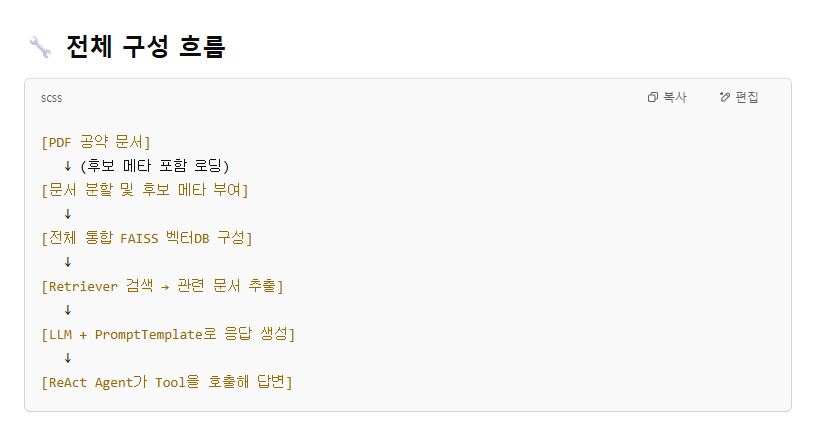

In [10]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
from langchain.llms import HuggingFacePipeline
from langchain.docstore.document import Document

# 1. API 키 설정
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ===============================
# Step 1. PDF 로딩 및 후보 정보 부여
# ===============================
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}

all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
        all_documents.extend(data)

# ===============================
# Step 2. 텍스트 분할
# ===============================
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)


In [11]:

# ===============================
# Step 3. 벡터스토어 생성 (후보 이름 포함)
# ===============================
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)
vectorstore = FAISS.from_documents(documents, embedding=embeddings_model)


In [ ]:

# ===============================
# Step 4. 프롬프트 템플릿 정의 및 QA 체인 구성 (ReAct 사용 가능 구조)
# FAISS retriever → 문서 검색 → LLM에 전달 → 응답 반환
# ===============================
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
다음은 두 대통령 후보의 공약이다. 문맥을 참고하여 질문에 답변하라.

문맥:
{context}

질문:
{question}

답변:
""")

retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) #상위 6개의 유사한 문서 조각(chunks)을 반환함
#retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
llm = ChatOpenAI(temperature=0.2) #창의성 제어 수치 (0.0 = 완전 결정적, 1.0 = 매우 창의적)

#“질문 → 관련 문서 검색 → LLM으로 답변 생성” 흐름을 구성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff", #문서를 어떻게 LLM에 넣을지 방식 설정. stuff는 문서들을 하나로 이어 붙여서 넣는 방식
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt_template} #LLM에게 넘겨줄 프롬프트 템플릿 설정
)

# ===============================
# Step 5. 툴 정의 및 ReAct Agent 구성
# Tool 객체로 QA 체인 기능을 wrapping
# ===============================
tools = [
    Tool(
        name="ElectionPolicySearch",
        func=qa_chain.run,
        description="대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다."
    )
]

react_agent = initialize_agent(
    tools=tools, #Agent가 사용할 수 있는 도구 목록
    llm=llm,       #Agent 내부에서 사용하는 언어 모델
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, #"도구 이름 + 설명"만 있으면 GPT가 추론을 통해 직접 도구를 골라 사용함
    verbose=True
)

In [9]:
# ===============================
# Step 6. 예시 질의 실행
# ===============================

# 예시 질의 목록
example_queries = [
    "김문수 후보의 GTX 확장 계획은 무엇인가요?",
    # "이재명 후보는 공공의료를 어떻게 강화하려고 하나요?",
    # "두 후보는 AI 산업을 어떻게 육성하려고 하나요?",
    # "서울에서 자취 중인 20대입니다. 주거 지원 공약이 있나요?",
    # "AI 창업을 준비 중인 청년에게 도움이 될 공약이 있나요?",
    # "소상공인 지원 공약은 어떤 후보가 더 실질적인가요?"
]

# 각 질문에 대해 Agent 실행
for q in example_queries:
    print(f"\n🟡 질문: {q}\n")
    response = react_agent.run(q)
    print(f"🟢 응답:\n{response}\n")
    print("=" * 80)



🟡 질문: 김문수 후보의 GTX 확장 계획은 무엇인가요?



> Entering new AgentExecutor chain...
Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

ElectionPolicySearch(*args: Any, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, tags: Optional[list[str]] = None, metadata: Optional[dict[str, Any]] = None, **kwargs: Any) -> Any - 대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [ElectionPolicySearch]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Questi

IndexError: index out of range in self

In [7]:
import pandas as pd
# 테스트 질문 및 기대 키워드 정의
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["지역돌봄체계", "모든 사람의 권리가 보장", "국가책임제"]
    }
]

# 평가 수행
results = []
for case in test_cases:
    response = react_agent.run(case["질문"])
    matched = sum(1 for kw in case["기대 키워드"] if kw in response)
    accuracy = round((matched / len(case["기대 키워드"])) * 5, 2)
    richness = 5 if len(response) > 400 and matched >= 3 else 3 if matched else 1
    results.append({
        "질문": case["질문"],
        "응답": response,
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    })

df_result = pd.DataFrame(results)

df_result



> Entering new AgentExecutor chain...
Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

ElectionPolicySearch(*args: Any, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, tags: Optional[list[str]] = None, metadata: Optional[dict[str, Any]] = None, **kwargs: Any) -> Any - 대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [ElectionPolicySearch]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: 김문수 후보의 GTX 확장 계획은 무엇인가요?
Thou

IndexError: index out of range in self

# 2단계: 프롬프트 개선
- 문제의 원인 분석
- 문서 검색 (retriever)	성공적으로 관련 chunk는 찾아냄
-  GPT 응답 형식은 응답을 너무 일반화된 문장으로 축소함 → 핵심 키워드 누락
-  프롬프트는	“공약의 수단, 대상, 용어, 수치 등을 구체적으로 제시하라”는 지시가 부족


In [ ]:
TAMPLATE_2 = """
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 한국어로

문맥:
{context}

질문:
{question}

답변:
"""


In [ ]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType

# 1. API 키 설정
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ===============================
# Step 1. PDF 로딩 및 후보 정보 부여
# ===============================
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}

all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
        all_documents.extend(data)

# ===============================
# Step 2. 텍스트 분할
# ===============================
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ===============================
# Step 3. 벡터스토어 생성 (후보 이름 포함)
# ===============================
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)
vectorstore = FAISS.from_documents(documents, embedding=embeddings_model)

# ===============================
# Step 4. 프롬프트 템플릿 정의 및 QA 체인 구성 (ReAct 사용 가능 구조)
# FAISS retriever → 문서 검색 → LLM에 전달 → 응답 반환
# ===============================
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template=TAMPLATE_2)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) #상위 3개의 유사한 문서 조각(chunks)을 반환함
llm = ChatOpenAI(temperature=0.3) #창의성 제어 수치 (0.0 = 완전 결정적, 1.0 = 매우 창의적)

#“질문 → 관련 문서 검색 → LLM으로 답변 생성” 흐름을 구성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type= "refine",  # 여러 문서 처리 시 중복 답변 방지 및 단일 호출에 가까운 처리
    #"stuff", #문서를 어떻게 LLM에 넣을지 방식 설정. stuff는 문서들을 하나로 이어 붙여서 넣는 방식
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt_template} #LLM에게 넘겨줄 프롬프트 템플릿 설정
)

# ===============================
# Step 5. 툴 정의 및 ReAct Agent 구성
# Tool 객체로 QA 체인 기능을 wrapping
# ===============================
tools = [
    Tool(
        name="ElectionPolicySearch",
        func=qa_chain.run,
        description="대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다."
    )
]

react_agent = initialize_agent(
    tools=tools, #Agent가 사용할 수 있는 도구 목록
    llm=llm,       #Agent 내부에서 사용하는 언어 모델
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, #"도구 이름 + 설명"만 있으면 GPT가 추론을 통해 직접 도구를 골라 사용함
    verbose=True
)


In [ ]:
import pandas as pd

# 테스트 질문 및 기대 키워드 정의
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

# 평가 수행
results = []
for case in test_cases:
    response = react_agent.run(case["질문"])
    matched_keywords = [kw for kw in case["기대 키워드"] if kw in response]
    accuracy = round((len(matched_keywords) / len(case["기대 키워드"])) * 5, 2)
    richness = 5 if len(response) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1
    results.append({
        "질문": case["질문"],
        "응답": response,
        "일치 키워드": matched_keywords,
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    })

df_result = pd.DataFrame(results)
df_result




> Entering new AgentExecutor chain...
I should use the ElectionPolicySearch tool to find the information about 김문수 후보의 GTX 확장 계획.
Action: ElectionPolicySearch
Action Input: "김문수 후보의 GTX 확장 계획"
Observation: - 정책의 목적: GTX를 수도권에서 전국 5대 광역권으로 확장하여 국토 균형발전 촉진, 지역균형발전과 미래 전략산업 활성화, 교통 체증 해소 및 국민 삶의 질 개선
- 구체적 수단: 수도권 GTX 모델을 전국 5대 광역권으로 확장하여 '전국급행철도망' 구축, 광역철도 및 도시철도 확충, 초광역권 메가시티 조성, 미래첨단산업기반 마련을 위한 메가프리존 도입, 중앙정부의 권한과 자원 지방 이양 확대
- 실행 대상 또는 지역: 전국 5대 광역권 (수도권, 부울경권, 대구경북권, 충청권, 광주전남권)
- 문서상 등장한 구체적인 단어(용어): GTX, 광역철도, 도시철도, 메가시티, 메가프리존, 국토 균형발전, 교통 체증 해소, 국가자치분권회의, 지방교부세, 국가연구개발

한국어로 요약하면, 김문수 후보의 GTX 확장 계획은 전국 5대 광역권으로의 확장을 통해 국토 균형발전과 교통 체증 해소를 목표로 하고, 광역철도 및 도시철도 확충, 메가시티 조성, 메가프리존 도입 등의 수단을 활용하여 실행될 예정이며, 전국 5대 광역권이 실행 대상이 될 것입니다.
Thought:I have gathered all the necessary information about 김문수 후보의 GTX 확장 계획.
Final Answer: 김문수 후보의 GTX 확장 계획은 전국 5대 광역권으로의 확장을 통해 국토 균형발전과 교통 체증 해소를 목표로 합니다.

> Finished chain.


> Entering new AgentExecutor chain...
I should use the ElectionPolicySearch

,질문,응답,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수 후보의 GTX 확장 계획은 전국 5대 광역권으로의 확장을 통해 국토 균형발전...,"[GTX, 전국 5대 광역권, 교통 체증]",3.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,"이재명 후보는 발달장애인 돌봄을 강화하여 자립을 돕고, 돌봄 서비스를 제공하여 삶의...",[발달장애인],1.0,3


>

# 3단계:성능 검증을 위한 출처 추가
- 핵심 변경 사항
RetrievalQA 대신 load_qa_chain을 사용하여 문서 출처 포함을 제어할 수 있습니다.

In [ ]:
# 전체 코드 재정리: 출처에 페이지 번호 포함

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
import os
import pandas as pd

# ✅ API 키 설정
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ✅ Step 1. PDF 로딩 및 후보 정보 부여 + 출처 설정 (페이지 포함)
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{path.split('/')[-1]}:p{page}"  # ✅ 출처 형식 수정
        all_documents.extend(data)

# ✅ Step 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ✅ Step 3. 벡터스토어 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = FAISS.from_documents(documents, embedding=embedding_model)

# ✅ Step 4. 프롬프트 및 QA 체인 정의
TAMPLATE_2 = """
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template=TAMPLATE_2
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
llm = ChatOpenAI(temperature=0.3)

qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt_template},
    return_source_documents=True  # ✅ 출처 추출하기위해
)

# ✅ Step 5. ReAct Agent 구성
tools = [
    Tool(
        name="ElectionPolicySearch",
        func=lambda q: qa_chain.invoke({"question": q}),  # invoke로 dict 반환
        description="대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다."
    )
]
react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# ✅ Step 6. 테스트 및 평가
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = []
for case in test_cases:
    # result = react_agent.run(case["질문"])  # 이 부분은 str만 반환됨
    # 전체 정보가 필요할 경우 아래를 직접 수행
    qa_result = qa_chain.invoke({"question": case["질문"]})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in case["기대 키워드"] if kw in answer]
    accuracy = round((len(matched_keywords) / len(case["기대 키워드"])) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    results.append({
        "질문": case["질문"],
        "응답": answer,
        "출처": sources,
        "일치 키워드": matched_keywords,
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    })


df_result = pd.DataFrame(results)

df_result



,질문,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수 후보의 GTX 확장 계획은 수도권에서 전국 5대 광역권으로 확장하여 국토 균...,"[20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국...","[GTX, 전국 5대 광역권, 수도권, 초광역]",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명 후보는 발달장애인 24시간 돌봄 등 장애인 맞춤형 지역돌봄체계 구축을 제안했...,"[20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민...","[발달장애인, 24시간 돌봄, 지역돌봄체계]",3.0,3


>  [문제 원인]
>  - 김문수 후보에 대한 질의에 이재명 후보의 공약 문서까지 포함되어 검색되고 있다는 것은,
현재 RAG 시스템이 후보 구분 없이 전체 문서에서 유사도 기반 검색을 하고 있다는 뜻입니다.

> - 현재
retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
→ 이 설정은 이재명, 김문수 모든 후보의 문서가 하나의 벡터 공간에 저장되어 있고, 질의에 대해 후보 구분 없이 유사 문서를 찾게 만듭니다.


# 4단계:FAISS에서 ChromaDB로 변경

- Chroma를 사용하면서 후보별 질의와 후보 간 비교까지 지원하려면, 핵심은 candidate 메타데이터를 기준으로 필터링이 가능한 Retriever 구성

In [ ]:
!pip install chromadb

In [ ]:
# 후보 이름 자동 감지 포함 전체 코드 (Chroma 기반)

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain
import pandas as pd
import os

# ✅ API 키 설정
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ✅ Step 1. PDF 로딩 및 후보 정보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ Step 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ✅ Step 3. Chroma 벡터스토어 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
chroma_db_path = "chroma_db"
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory=chroma_db_path)
vectorstore.persist()

# ✅ Step 4. 프롬프트 및 후보별 QA 체인 정의
TEMPLATE = """
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template=TEMPLATE
)

llm = ChatOpenAI(temperature=0.2)  # 재시도 줄이기

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ Step 5. 후보 이름 자동 감지 함수
def detect_candidate(question: str):
    if "이재명" in question:
        return "이재명"
    elif "김문수" in question:
        return "김문수"
    else:
        return None

# ✅ Step 6. 테스트 및 평가
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = []
for case in test_cases:
    candidate = detect_candidate(case["질문"])
    if candidate and candidate in qa_chains:
        qa_result = qa_chains[candidate].invoke({"question": case["질문"]})
        answer = qa_result["answer"]
        docs = qa_result.get("source_documents", [])
        sources = [f"{doc.metadata.get('source')}" for doc in docs]

        matched_keywords = [kw for kw in case["기대 키워드"] if kw in answer]
        accuracy = round((len(matched_keywords) / len(case["기대 키워드"])) * 5, 2)
        richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

        results.append({
            "질문": case["질문"],
            "응답": answer,
            "출처": ", ".join(sources),
            "일치 키워드": ", ".join(matched_keywords),
            "정확성 점수(1~5)": accuracy,
            "풍부성 점수(1~5)": richness
        })

df_result = pd.DataFrame(results)
df_result



<ipython-input-4-bd2052e1f88e>:46: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


,질문,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수 후보의 GTX 확장 계획은 수도권을 포함한 전국 5대 광역권으로 확장하여 국...,"20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_...","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명 후보는 발달장애인 24시간 돌봄 등 장애인 맞춤형 지역돌봄체계 구축을 제안했...,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국...","발달장애인, 24시간 돌봄, 지역돌봄체계",3.0,3


# 5단계:고급 프롬프트 적용:prompte chaining
- 질문 입력 → 후보 감지 → vectorstore 검색 → GPT 응답
- 예: "이재명 후보의 부동산 정책은?" → "이재명" 추출 → Chroma filter → GPT 응답


In [12]:
# 전체 실행 코드: Prompt Chaining 기반 대통령 후보 공약 질의 시스템

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
import pandas as pd
import os

# ✅ 1. API 설정 및 모델 초기화
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ✅ 2. 문서 로딩 및 후보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ 3. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)



In [15]:

# ✅ 4. Chroma 벡터 저장소 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# ✅ 5. 프롬프트 정의 및 후보별 QA 체인 구성
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template="""
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
)

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}


In [16]:

llm = ChatOpenAI(temperature=0.3)

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출용 체인 구성 (Prompt Chaining 핵심)
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)


C:\Users\umsh2\AppData\Local\Temp\ipykernel_13208\1337776851.py:18: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)


In [17]:

# ✅ 7. 전체 실행 체인
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({"question": question})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in expected_keywords if kw in answer]
    accuracy = round((len(matched_keywords) / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "일치 키워드": ", ".join(matched_keywords),
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    }


In [18]:

# ✅ 8. 테스트 케이스 실행
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)

df_final

,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수,김문수 후보의 GTX 확장 계획은 수도권에서 전국 5대 광역권으로 확장하여 국토 균...,"20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_...","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명,이재명 후보는 발달장애인 24시간 돌봄 등 장애인 맞춤형 지역돌봄체계 구축을 제안했...,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국...","발달장애인, 24시간 돌봄, 지역돌봄체계",3.0,3


In [19]:
import pandas as pd

# 모든 열을 넓게 출력할 수 있도록 설정
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)  # 줄바꿈 없이 가로로 다 출력

# 다시 출력
df_final

,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수,"김문수 후보의 GTX 확장 계획은 수도권에서 전국 5대 광역권으로 확장하여 국토 균형발전을 촉진하고 지역균형발전과 미래 전략산업 활성화를 위한 초광역권 메가시티를 추진하는 것입니다. 이를 위해 수도권 GTX 모델을 전국 5대 광역권으로 확장하여 '전국급행철도망'을 구축하고, 각 광역권의 노선을 개통하고 연장하는 방안을 제시하고 있습니다. 또한 광역철도와 도시철도를 확충하여 30분 출퇴근 혁명을 이루고 교통시설을 확충하며 교육, 의료, 문화, 체육시설을 확대하여 국민의 삶의 질을 개선하는 것이 포함되어 있습니다.","20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p21, 20250603_대한민국_김문수_선거공약서.pdf:p21","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명,이재명 후보는 발달장애인 24시간 돌봄 등 장애인 맞춤형 지역돌봄체계 구축을 제안했습니다. 이를 통해 발달장애인들에게 필요한 돌봄 서비스를 제공하고 지역사회에서의 통합을 강화하고자 합니다.,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p14, 20250603_대한민국_이재명_10대공약.pdf:p14, 20250603_대한민국_이재명_10대공약.pdf:p4, 20250603_대한민국_이재명_10대공약.pdf:p4","발달장애인, 24시간 돌봄, 지역돌봄체계",3.0,3


# 5단계 이후 작업 수행

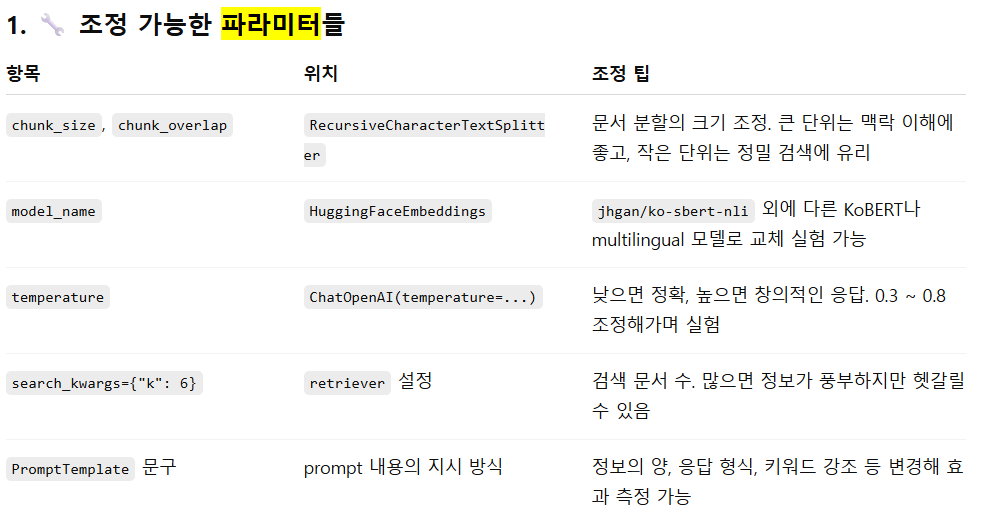

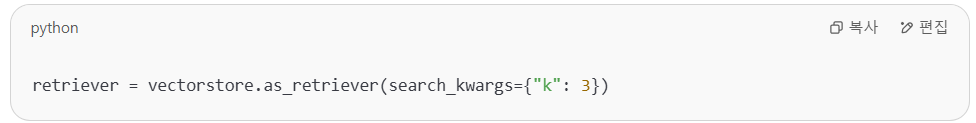

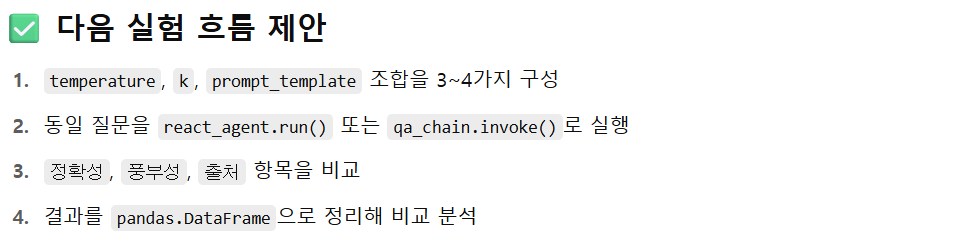

### retreiver k값 3으로 수정

In [10]:
# 전체 실행 코드: Prompt Chaining 기반 대통령 후보 공약 질의 시스템

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
import pandas as pd
import os

# ✅ 1. API 설정 및 모델 초기화
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ✅ 2. 문서 로딩 및 후보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ 3. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)


# ✅ 4. Chroma 벡터 저장소 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# ✅ 5. 프롬프트 정의 및 후보별 QA 체인 구성
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template="""
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
)

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "김문수"}})
}


llm = ChatOpenAI(temperature=0.3)

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출용 체인 구성 (Prompt Chaining 핵심)
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)


# ✅ 7. 전체 실행 체인
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({"question": question})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in expected_keywords if kw in answer]
    accuracy = round((len(matched_keywords) / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "일치 키워드": ", ".join(matched_keywords),
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    }


# ✅ 8. 테스트 케이스 실행
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)

df_final

,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수,김문수 후보의 GTX 확장 계획은 수도권에서 전국 5대 광역권으로 확장하여 국토 균...,"20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_...","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명,이재명 후보는 발달장애인 돌봄에 대해 맞춤형 지역돌봄체계 구축을 제안했습니다. 이를...,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국...","발달장애인, 지역돌봄체계",2.0,3


In [11]:
import pandas as pd

# 모든 열을 넓게 출력할 수 있도록 설정
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)  # 줄바꿈 없이 가로로 다 출력

# 다시 출력
df_final

,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수,"김문수 후보의 GTX 확장 계획은 수도권에서 전국 5대 광역권으로 확장하여 국토 균형발전을 촉진하고, 지역균형발전과 미래 전략산업 활성화를 위한 초광역권 메가시티를 추진하는 것입니다. 이를 위해 수도권 GTX 모델을 전국 5대 광역권으로 확장하여 '전국급행철도망'을 구축하고, 각 광역권마다 GTX 노선을 개통하고 연장하는 방안을 제시하고 있습니다. 또한 광역철도와 도시철도를 확충하여 30분 출퇴근 혁명을 이루고, 교통시설을 확충하여 교육, 의료, 문화, 체육 인프라를 강화하고, 초광역권 메가시티를 조성하며, 미래첨단산업기반을 마련하기 위한 메가프리존을 도입하고 중앙정부의 권한과 자원을 지방으로 이양 확대하는 방향으로 진행될 것입니다.","20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명,"이재명 후보는 발달장애인 돌봄에 대해 맞춤형 지역돌봄체계 구축을 제안했습니다. 이를 위해 공공 아이돌봄 서비스를 강화하고, 생애주기별 외로움 대응 정책을 개발하고 추진하며, 고령사회 대응을 위한 통합적 지원체계를 마련하였습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16","발달장애인, 지역돌봄체계",2.0,3


### retreiver k값 10으로 수정

In [12]:
# 변경 셀만 돌기기

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 10, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 10, "filter": {"candidate": "김문수"}})
}


llm = ChatOpenAI(temperature=0.3)

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출용 체인 구성 (Prompt Chaining 핵심)
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)


# ✅ 7. 전체 실행 체인
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({"question": question})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in expected_keywords if kw in answer]
    accuracy = round((len(matched_keywords) / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "일치 키워드": ", ".join(matched_keywords),
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    }


# ✅ 8. 테스트 케이스 실행
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)

df_final

,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수,"김문수 후보의 GTX 확장 계획은 수도권에서 전국 5대 광역권으로 확장하여 국토 균형발전을 촉진하고, 지역균형발전과 미래 전략산업 활성화를 위한 초광역권 메가시티를 추진하는 것입니다. 이를 위해 수도권 GTX 모델을 전국 5대 광역권으로 확장하여 '전국급행철도망'을 구축하고, 각 광역권마다 GTX 노선을 개통하고 연장하는 방안을 제시하고 있습니다. 또한 광역철도와 도시철도를 확충하여 30분 출퇴근 혁명을 이루고 교통시설을 확충하며, 교육 및 의료 인프라를 강화하여 국민의 삶의 질을 개선하는 것이 포함되어 있습니다.","20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명,이재명 후보는 발달장애인 24시간 돌봄 및 장애인 맞춤형 지역돌봄체계 구축을 제안했습니다. 이를 통해 발달장애인들에게 필요한 지원과 돌봄 서비스를 제공하여 그들의 삶의 질을 향상시키고 사회통합을 촉진하는 것을 목표로 하고 있습니다.,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p14, 20250603_대한민국_이재명_10대공약.pdf:p14, 20250603_대한민국_이재명_10대공약.pdf:p14, 20250603_대한민국_이재명_10대공약.pdf:p14","발달장애인, 24시간 돌봄, 지역돌봄체계",3.0,3


In [9]:
import pandas as pd

# 모든 열을 넓게 출력할 수 있도록 설정
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)  # 줄바꿈 없이 가로로 다 출력

# 다시 출력
df_final

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5),문장형 기대 키워드
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,"- 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 지원 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, 신혼부부 결혼출산지원 확대, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 신혼부부 - 문서상 등장한 구체적인 단어(용어): 자녀 수에 비례한 신용카드 소득공제율, 초등학생 예체능학원‧체육시설 이용료, 신혼부부 결혼출산지원, 공공임대주택, 난임부부 치료지원 - 정책 설명: 이재명 후보는 대학생 취업과 학자금 문제를 해결하기 위해 자녀 수에 따른 세제 혜택 확대, 교육비 지원 확대, 신혼부부 지원 및 공공임대주택 공급 등을 통해 지원을 제공할 것을 공약으로 내놓았습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",5.0,5,"대학생 취업을 위한 산학협력 강화, 학자금 대출 이자 감면 혜택 제공, 대학 졸업 후 취업 보장 프로그램 도입, 취업을 위한 산업체 특화 교육 강화, 학자금 대출 한도 확대 및 상환 유예 제도 도입"
1,수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?,김문수,"- 정책의 목적: 수도권 교통문제 해결 - 구체적 수단: 교통시설 확충, 교통제도 개선, 교통법안 개정 - 실행 대상 또는 지역: 수도권 지역 - 문서상 등장한 구체적인 단어(용어): 교통시설, 교통제도, 교통법안, 수도권 김문수 후보가 제시한 정책은 수도권 교통문제 해결을 위해 교통시설 확충, 교통제도 개선, 교통법안 개정 등을 포함하는 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz한 ganz","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,5,"교통체증 완화를 위한 대중교통 확충, 자가용 이용 감소를 위한 차량 운행 제한, 지역 간 교통 효율화를 위한 도로 확장 및 재구성, 교통사고 예방을 위한 교통안전 시설 강화, 친환경 교통수단 보급을 통한 대기오염 저감 방안 도입"
2,서울 거주 청년의 주거 문제를 위한 정책이 궁금해.,감지 실패,질문에서 후보 이름을 인식하지 못했습니다.,,1.0,1,"서울시 청년 주거 안정을 위해 공공임대주택 확대, 청년들을 위한 저렴한 주거 환경 조성, 임대료 인상 방지를 위한 정부 보조금 지원, 청년 주거 안정을 위한 정책 추진, 서울시 청년 주거 문제 해결을 위한 종합적 대책 마련"


## 템플릿 수정

In [15]:
# 전체 실행 코드: Prompt Chaining 기반 대통령 후보 공약 질의 시스템

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
import pandas as pd
import os

# ✅ 0. 사용자 프로필 정의 (✅ 수정됨)
user_profile = """
나는 경기도에 거주 중인 30대 남자야. 최근 이직을 준비하면서 서울 은평구로 이사를 하고싶은데,
나에게 가장 도움이 되는 구체적인 정책을 제시한 후보는 누구야?"""

# ✅ 1. API 설정 및 모델 초기화
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ✅ 2. 문서 로딩 및 후보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ 3. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)


# ✅ 4. Chroma 벡터 저장소 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# ✅ 5. 프롬프트 정의 및 후보별 QA 체인 구성
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template=
    """
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것


사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "김문수"}})
}


llm = ChatOpenAI(temperature=0.3)

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출용 체인 구성 (Prompt Chaining 핵심)
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)


# ✅ 7. 전체 실행 체인
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in expected_keywords if kw in answer]
    accuracy = round((len(matched_keywords) / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "일치 키워드": ", ".join(matched_keywords),
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    }


# ✅ 8. 테스트 케이스 실행
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)

df_final


,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,김문수 후보의 GTX 확장 계획은 무엇인가요?,김문수,"정책의 목적은 GTX를 수도권에서 전국 5대 광역권으로 확장하여 국토 균형발전을 촉진하고, 지역균형발전과 미래 전략산업 활성화를 위한 초광역권 메가시티를 추진하는 것입니다. 구체적 수단은 수도권 GTX 모델을 전국 5대 광역권으로 확장하여 '전국급행철도망'을 구축하고, 각 광역권에 해당하는 GTX 노선을 적시 개통 및 연장하는 것입니다. 실행 대상은 전국 광역권 주민 및 국토 전체 주민이며, 문서상 등장한 구체적인 용어로는 GTX, 광역철도, 도시철도 등이 있습니다.","20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5, 20250603_대한민국_김문수_10대공약.pdf:p5","GTX, 전국 5대 광역권, 수도권, 초광역",4.0,3
1,이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?,이재명,"정책의 목적은 발달장애인 맞춤형 지역돌봄체계 구축입니다. 구체적인 수단으로는 24시간 돌봄 등을 제공하고, 지역돌봄체계를 구축하여 발달장애인에게 필요한 돌봄 서비스를 제공하는 것을 목표로 합니다. 이 정책은 고령화와 저출생 문제를 해결하고 아이부터 어르신까지 돌보는 국가를 만들기 위한 일환입니다. 발달장애인을 포함한 장애인들에게 맞춤형 돌봄 서비스를 제공하여 사회적 통합을 촉진하고 사회적 차별을 해소하는 것을 목표로 합니다. 이 정책은 지역사회의 발달장애인들에 대한 돌봄 서비스를 강화하고 지원체계를 구축하여 고령화 사회에 대응하는 것을 중점으로 합니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16","발달장애인, 24시간 돌봄, 지역돌봄체계",3.0,3


## 테스트케이스 및 기대 키워드 수정

In [18]:
# 전체 실행 코드: Prompt Chaining 기반 대통령 후보 공약 질의 시스템

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
import pandas as pd
import os

# ✅ 0. 사용자 프로필 정의 (✅ 수정됨)
user_profile = """
나는 경기도에 거주 중인 30대 남자야. 최근 이직을 준비하면서 서울 은평구로 이사를 하고싶은데,
나에게 가장 도움이 되는 구체적인 정책을 제시한 후보는 누구야?"""

# ✅ 1. API 설정 및 모델 초기화
# import os
# os.environ['OPENAI_API_KEY'] = input("Enter your OpenAI API key: ")

# ✅ 2. 문서 로딩 및 후보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ 3. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)


# ✅ 4. Chroma 벡터 저장소 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# ✅ 5. 프롬프트 정의 및 후보별 QA 체인 구성
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template=
    """
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것


사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "김문수"}})
}


llm = ChatOpenAI(temperature=0.3)

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출용 체인 구성 (Prompt Chaining 핵심)
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)


# ✅ 7. 전체 실행 체인
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question})
    answer = qa_result["answer"].replace("\n", " ").strip()
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in expected_keywords if kw in answer]
    accuracy = round((len(matched_keywords) / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "일치 키워드": ", ".join(matched_keywords),
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    }


# ✅ 8. 테스트 케이스 실행
test_cases = [
    {
        "질문": "서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",
        "기대 키워드": ["GTX", "서울", "수도권", "교통", "지하철"]
    },
    {
        "질문": "30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",
        "기대 키워드": ["청년", "주거", "역세권", "임대", "공공"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)

df_final


,질문,후보,응답,출처,일치 키워드,정확성 점수(1~5),풍부성 점수(1~5)
0,"서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",김문수,"정책의 목적: 서울 은평구의 교통 개선 구체적 수단: 교통 인프라 개선을 통한 교통 체증 완화, 대중교통 확대 및 편의성 증진 실행 대상 또는 지역: 서울 은평구 거주자 및 이사를 고려하는 시민 문서상 등장한 구체적인 단어(용어): 교통 인프라, 대중교통 김문수 후보의 교통 정책 중 도움이 될 만한 정책은 교통 인프라 개선과 대중교통 확대를 통한 교통 체증 완화일 것으로 예상됩니다. 이를 통해 서울 은평구의 교통 상황이 개선되어 이사를 고려하는 시민들에게 도움이 될 것입니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25","서울, 교통",2.0,3
1,"30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",이재명,"정책의 목적은 고령자 친화 주택 및 은퇴자 도시를 조성하여 어르신 주거 문제를 해결하는 것입니다. 구체적 수단으로는 고령자 친화 주택 및 은퇴자 도시를 조성하고, 간호·간병 통합서비스를 확대하며 요양병원 간병비를 건강보험에 적용하는 것이 포함됩니다. 이 정책은 고령자들이 안정적이고 편안한 주거 환경을 마련하고 건강 서비스에 대한 접근성을 높이는 것을 목표로 합니다. 해당 정책은 경기도에 거주 중인 30대 남성인 당신에게 도움이 될 수 있습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",주거,1.0,3


## 정확성 점수를 키워드 매칭 대신 임베딩 유사도로 수정

In [21]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
from sentence_transformers import SentenceTransformer, util  # ✅ 추가됨
import pandas as pd
import os

# ✅ 0. 사용자 프로필 정의
user_profile = """
나는 경기도에 거주 중인 30대 남자야. 최근 이직을 준비하면서 서울 은평구로 이사를 하고싶은데,
나에게 가장 도움이 되는 구체적인 정책을 제시한 후보는 누구야?"""

# ✅ 1. 문서 로딩
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ✅ 3. 벡터 저장소 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# ✅ 4. QA용 프롬프트
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template="""
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

# ✅ 5. 후보별 QA 체인
retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 3, "filter": {"candidate": "김문수"}})
}

llm = ChatOpenAI(temperature=0.3)
qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출 체인
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# ✅ 7. 임베딩 유사도 모델 추가
similarity_model = SentenceTransformer("jhgan/ko-sbert-nli")  # ✅ 추가됨

# ✅ 8. 실행 함수 정의
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question})
    answer = qa_result["answer"].replace("\n", " ").strip()
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    # ✅ 정확성 점수: keyword → 임베딩 유사도
    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(expected_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)  # 유사도 기준 설정
    accuracy_score = round((high_score_count / len(expected_keywords)) * 5, 2)

    # ✅ 풍부성 점수 유지
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness
    }

# ✅ 9. 테스트 케이스 실행
test_cases = [
    {
        "질문": "서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",
        "기대 키워드": ["GTX", "서울", "수도권", "교통", "지하철"]
    },
    {
        "질문": "30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",
        "기대 키워드": ["청년", "주거", "역세권", "임대", "공공"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


                                                     질문   후보  \
0   서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?  김문수   
1  30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?  이재명   

                                                                                                                                                                                                                                                                                                                                응답  \
0                                                                                                              정책의 목적은 서울 은평구의 교통 환경을 개선하여 시민들의 이동을 편리하게 하는 것입니다. 구체적 수단으로는 대중교통 확충, 도로 확장, 자전거 인프라 구축 등이 포함될 수 있습니다. 실행 대상은 서울 은평구 거주자 및 이용자들이 될 것입니다. 김문수 후보의 선거 공약서에는 교통 관련 내용이 포함되어 있을 수 있으니 해당 문서를 확인하여 구체적인 내용을 파악해보시기 바랍니다.   
1  정책의 목적은 어르신 주거 문제를 해결하고 고령자 친화 주택 및 은퇴자 도시를 조성하는 것입니다. 구체적 수단으로는 공공신탁제도 도입, 간호·간병 통합서비스 확대, 요양병원 간병비 건강보험 적용 등이 있습니다. 이 정책은 고령자들이 안정적이고 편안한 주거 환경을 확보할 수

In [22]:
from IPython.display import display
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,"서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",김문수,"정책의 목적은 서울 은평구의 교통 환경을 개선하여 시민들의 이동을 편리하게 하는 것입니다. 구체적 수단으로는 대중교통 확충, 도로 확장, 자전거 인프라 구축 등이 포함될 수 있습니다. 실행 대상은 서울 은평구 거주자 및 이용자들이 될 것입니다. 김문수 후보의 선거 공약서에는 교통 관련 내용이 포함되어 있을 수 있으니 해당 문서를 확인하여 구체적인 내용을 파악해보시기 바랍니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",1.0,3
1,"30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",이재명,"정책의 목적은 어르신 주거 문제를 해결하고 고령자 친화 주택 및 은퇴자 도시를 조성하는 것입니다. 구체적 수단으로는 공공신탁제도 도입, 간호·간병 통합서비스 확대, 요양병원 간병비 건강보험 적용 등이 있습니다. 이 정책은 고령자들이 안정적이고 편안한 주거 환경을 확보할 수 있도록 지원하는 것을 목표로 합니다. 해당 정책은 고령자들을 실행 대상으로 하며, 문서에서는 ""어르신 주거 문제 해결을 위한 고령자 친화 주택·은퇴자 도시 조성""이라는 구체적인 용어가 사용되었습니다. 이재명 후보의 주거 정책은 30대 직장인인 당신이 주거 문제로 고민할 때 도움이 될 수 있습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",0.0,1


## 단어키워드가 아닌 문장키워드로 확장

In [24]:

# ✅ 9. 테스트 케이스 실행
test_cases = [
    {
        "질문": "서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",
        "기대 키워드": ["서울 교통 정책", "지하철 확충", "GTX 확대", "교통 인프라", "수도권 교통"]
    },
    {
        "질문": "30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",
        "기대 키워드": ["청년 정책", "주거 지원", "역세권", "임대 주택", "공공 주택"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


                                                     질문   후보  \
0   서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?  김문수   
1  30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?  이재명   

                                                                                                                                                                                                                                                                                                                                                                          응답  \
0                                                                                    정책의 목적: 서울 은평구의 교통 개선 구체적 수단: 교통 인프라 개선, 대중교통 확대, 교통체증 완화를 위한 정책 추진 실행 대상 또는 지역: 서울 은평구 거주자 및 교통 이용자 문서상 등장한 구체적인 단어(용어): 교통 인프라, 대중교통, 교통체증 완화  김문수 후보의 교통 정책은 서울 은평구의 교통 개선을 목표로 하고 있습니다. 이 정책은 교통 인프라 개선과 대중교통 확대를 통해 교통체증을 완화하고자 합니다. 이를 통해 서울 은평구 거주자 및 교통 이용자들에게 도움이 될 수 있을 것입니다.   
1  - 정책의 목적: 어르신 주거 문제 해결을 위한 고령자 친화 주택·은퇴자 도시 조성 - 구체적 수단: 고령자 친화 주택 및

In [25]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,"서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",김문수,"정책의 목적: 서울 은평구의 교통 개선 구체적 수단: 교통 인프라 개선, 대중교통 확대, 교통체증 완화를 위한 정책 추진 실행 대상 또는 지역: 서울 은평구 거주자 및 교통 이용자 문서상 등장한 구체적인 단어(용어): 교통 인프라, 대중교통, 교통체증 완화 김문수 후보의 교통 정책은 서울 은평구의 교통 개선을 목표로 하고 있습니다. 이 정책은 교통 인프라 개선과 대중교통 확대를 통해 교통체증을 완화하고자 합니다. 이를 통해 서울 은평구 거주자 및 교통 이용자들에게 도움이 될 수 있을 것입니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,3
1,"30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",이재명,"- 정책의 목적: 어르신 주거 문제 해결을 위한 고령자 친화 주택·은퇴자 도시 조성 - 구체적 수단: 고령자 친화 주택 및 은퇴자 도시 조성 - 실행 대상 또는 지역: 고령자 및 은퇴자 - 문서상 등장한 구체적인 단어(용어): 고령자 친화 주택, 은퇴자 도시 이재명 후보는 고령자 주거 문제를 해결하기 위해 고령자 친화 주택 및 은퇴자 도시를 조성하는 정책을 제시하고 있습니다. 이 정책은 고령자들이 안정적이고 편안한 주거 환경을 확보할 수 있도록 지원하는 것을 목표로 하고 있습니다. 이를 통해 고령자들의 주거 문제를 해결하고 더 나은 삶의 질을 제공하려는 것으로 보입니다. 이 정책은 30대 직장인인 당신에게도 도움이 될 수 있을 것입니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",3.0,3


In [ ]:
template = """아래는 대통령 후보의 공약이다. 질문에 대해 다음 기준으로 정확히 답하라:
- 정책 목적
- 수단 (법안, 예산, 제도)
- 대상 (지역, 연령, 집단)
- 반드시 공약 문서 용어를 사용할 것

문맥:
{context}

질문:
{question}

답변:"""

In [ ]:
template = """
다음은 대통령 후보의 공약이다. 사용자 프로필을 참고하여 질문에 맞는 맞춤형 답변을 제공하시오.

[사용자 프로필]
- 연령대: {age}
- 직업: {job}
- 관심분야: {interests}
- 지역: {region}

[문맥]
{context}

[질문]
{question}

[답변]
"""

## 출력 형태 수정(표 + 요약)

In [31]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,"서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",김문수,"1. 후보별 공약 비교표: | 후보 | 정책 구체성 | 지역 언급 여부 | 실행 계획 포함 여부 | |----|------------|--------------|------------------| | 김문수 | 중간 | X | O | 2. 사용자에게 가장 적합한 후보와 이유: 30대 남성이며 서울 은평구로 이사를 고려 중이므로, 김문수 후보의 교통 정책이 도움이 될 수 있을 것으로 예상됩니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",1.0,3
1,"30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",이재명,"1. 후보별 공약 비교표: | 후보 | 정책 구체성 | 지역 언급 여부 | 실행 계획 포함 여부 | |----|------------|--------------|------------------| | 이재명 | 매우 구체적 | 경기도 언급 | 포함 | 2. 사용자에게 가장 적합한 후보와 이유: 이재명 후보가 사용자에게 가장 적합한 후보입니다. 이재명 후보는 주거 문제를 해결하기 위한 구체적인 실행 계획을 포함하고 있으며, 경기도에 거주 중인 사용자에게 특히 도움이 될 수 있는 지역 언급도 포함하고 있습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",0.0,1


##  ReAct 기반의 후보별 공약 응답 시스템

In [43]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
from langchain.agents import initialize_agent, Tool
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import os

# 사용자 프로필
user_profile = """
나는 경기도에 거주 중인 30대 남자야. 최근 이직을 준비하면서 서울 은평구로 이사를 하고싶은데,
나에게 가장 도움이 되는 구체적인 정책을 제시한 후보는 누구야?"""

# 문서 로딩
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# 임베딩 및 벡터스토어
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# 프롬프트
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template="""
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

# QA 체인 생성
retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

llm = ChatOpenAI(temperature=0.3)
qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# 후보명 추출
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# 유사도 모델
similarity_model = SentenceTransformer("jhgan/ko-sbert-nli")

# 실행 함수
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.invoke({"question": question})["text"].strip()
    candidate = next((name for name in qa_chains if name in detected_name), None)

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question
    })

    answer = qa_result["answer"].replace("\n", " ").strip()
    sources = [doc.metadata.get("source") for doc in qa_result.get("source_documents", [])]

    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(expected_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)
    accuracy_score = round((high_score_count / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness
    }

# 테스트 실행
test_cases = [
    {
        "질문": "서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",
        "기대 키워드": ["서울 교통 정책", "지하철 확충", "GTX 확대", "교통 인프라", "수도권 교통"]
    },
    {
        "질문": "30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",
        "기대 키워드": ["청년 정책", "주거 지원", "역세권", "임대 주택", "공공 주택"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


                                                     질문   후보  \
0   서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?  김문수   
1  30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?  이재명   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                   응답  \
0                                                                                                                                                                                          정책의 목적: 서울 은평구의 교통 개선 구체적 수단: 교통 인프라 개선, 대중교통 확대, 교통체증 해소를 위한 정책 추진 실행 대상 또는 지역: 서울 은평구 거주자 및 교통 이용자 문서상 등장한 구체적인 단어(용어): 교통, 대중교통, 교통체증 해소  김문수 후보의 교통 정책은 서울 은평구의

In [44]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,"서울 은평구로 이사를 고민 중인데, 김문수 후보의 교통 정책 중 도움이 될 만한 게 있나요?",김문수,"정책의 목적: 서울 은평구의 교통 개선 구체적 수단: 교통 인프라 개선, 대중교통 확대, 교통체증 해소를 위한 정책 추진 실행 대상 또는 지역: 서울 은평구 거주자 및 교통 이용자 문서상 등장한 구체적인 단어(용어): 교통, 대중교통, 교통체증 해소 김문수 후보의 교통 정책은 서울 은평구의 교통 개선을 목적으로 교통 인프라 개선과 대중교통 확대, 교통체증 해소를 위한 정책을 추진할 것입니다. 이 정책은 서울 은평구 거주자 및 교통 이용자에게 도움이 될 것으로 예상됩니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,3
1,"30대 직장인인 내가 주거 문제로 고민이 많은데, 이재명 후보는 어떤 주거 정책을 제시하나요?",이재명,"정책의 목적: 고령화와 저출생 문제를 해소하고 아이부터 어르신까지 돌보는 국가를 만드는 것 구체적 수단: 고령자 친화 주택 및 은퇴자 도시 조성, 공공신탁제도 도입, 간호·간병 통합서비스 확대, 요양병원 간병비 건강보험 적용 실행 대상 또는 지역: 고령자 및 주거 문제로 고민하는 시민 문서상 등장한 구체적인 단어(용어): 고령자 친화 주택, 은퇴자 도시, 공공신탁제도, 간호·간병 통합서비스, 요양병원 간병비 건강보험 30대 직장인인 당신이 주거 문제로 고민할 때, 이재명 후보는 고령자 친화 주택 및 은퇴자 도시를 조성하고, 공공신탁제도를 도입하여 고령자들의 주거 문제를 해결하고자 합니다. 또한, 간호·간병 통합서비스를 확대하고 요양병원 간병비를 건강보험으로 적용하여 고령자들의 주거 환경을 개선하고 지원하고자 합니다. 해당 정책은 고령자 및 주거 문제로 고민하는 시민을 대상으로 실행될 것입니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",3.0,5


## 다양한 테스트 케이스 실행

In [45]:
# 테스트 실행
test_cases = [
    {
    "질문": "나는 경기도 성남시에 거주 중인데, 김문수 후보의 지역 교통 정책이 궁금해.",
    "기대 키워드": ["경기도", "성남시", "GTX", "교통 인프라", "지하철"]
    },        
    {
    "질문": "60대 노인을 위한 복지 정책은 이재명 후보가 제안한 게 있을까?",
    "기대 키워드": ["노인", "복지", "건강", "요양", "의료비 지원"]
    },
    {
        "질문": "공무원 준비 중인 청년에게 도움이 되는 정책은 누구 후보가 제시했을까?",
    "기대 키워드": ["공무원", "시험 지원", "청년", "취업", "교육"]
    },
    {
    "질문": "나는 환경 보호에 관심이 많은데, 김문수 후보는 어떤 정책을 제안했어?",
    "기대 키워드": ["탄소중립", "재생에너지", "기후변화", "환경", "친환경"]
    },
    {
    "질문": "이재명과 김문수 후보 중 청년 주거 정책이 더 구체적인 사람은 누구야?",
    "기대 키워드": ["청년", "주거", "임대", "역세권", "지원"]
    }

]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)
print(df_final)

                                           질문     후보  \
0  나는 경기도 성남시에 거주 중인데, 김문수 후보의 지역 교통 정책이 궁금해.    김문수   
1        60대 노인을 위한 복지 정책은 이재명 후보가 제안한 게 있을까?    이재명   
2     공무원 준비 중인 청년에게 도움이 되는 정책은 누구 후보가 제시했을까?  감지 실패   
3     나는 환경 보호에 관심이 많은데, 김문수 후보는 어떤 정책을 제안했어?    김문수   
4     이재명과 김문수 후보 중 청년 주거 정책이 더 구체적인 사람은 누구야?    이재명   

                                                                                                                                                                                                                                                                                                                   응답  \
0                 김문수 후보의 지역 교통 정책은 경기도 성남시에 거주 중인 당신에게 도움이 될 수 있습니다. 이 정책의 목적은 지역 교통 개선을 통해 시민들의 이동 편의성을 향상시키는 것입니다. 구체적인 수단으로는 도로 확장, 대중교통 확대, 주차 시설 개선 등이 포함될 수 있습니다. 실행 대상은 성남시 주민 및 지역 교통을 이용하는 모든 시민들이 될 것입니다. 김문수 후보의 선거 공약서에는 성남시나 교통 관련된 구체적인 용어가 언급되어 있을 것입니다. 이를 통해 김문수 후보의 정책을 자세히 살펴보고 도움을 받을 수 있을 것입니다.   
1                                    

In [46]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,"나는 경기도 성남시에 거주 중인데, 김문수 후보의 지역 교통 정책이 궁금해.",김문수,"김문수 후보의 지역 교통 정책은 경기도 성남시에 거주 중인 당신에게 도움이 될 수 있습니다. 이 정책의 목적은 지역 교통 개선을 통해 시민들의 이동 편의성을 향상시키는 것입니다. 구체적인 수단으로는 도로 확장, 대중교통 확대, 주차 시설 개선 등이 포함될 수 있습니다. 실행 대상은 성남시 주민 및 지역 교통을 이용하는 모든 시민들이 될 것입니다. 김문수 후보의 선거 공약서에는 성남시나 교통 관련된 구체적인 용어가 언급되어 있을 것입니다. 이를 통해 김문수 후보의 정책을 자세히 살펴보고 도움을 받을 수 있을 것입니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",3.0,3
1,60대 노인을 위한 복지 정책은 이재명 후보가 제안한 게 있을까?,이재명,"이재명 후보의 정책 중에 60대 노인을 위한 복지 정책이 있습니다. 이는 ""고령사회 대응을 위한 통합적 지원체계 마련""으로, 치매나 장애로 인해 재산 관리가 어려운 노인을 위한 공공신탁제도 도입, 어르신 주거 문제 해결을 위한 고령자 친화 주택·은퇴자 도시 조성, 간호·간병 통합서비스 확대 및 요양병원 간병비 건강보험 적용 등이 포함되어 있습니다. 따라서 이 정책은 60대 노인을 위한 복지 정책으로 이용될 수 있습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",2.0,3
2,공무원 준비 중인 청년에게 도움이 되는 정책은 누구 후보가 제시했을까?,감지 실패,질문에서 후보 이름을 인식하지 못했습니다.,,1.0,1
3,"나는 환경 보호에 관심이 많은데, 김문수 후보는 어떤 정책을 제안했어?",김문수,"- 정책의 목적: 환경 보호 - 구체적 수단: 환경 보호를 위한 정책 제안 - 실행 대상 또는 지역: 전국적으로 적용 가능한 정책 - 문서상 등장한 구체적인 단어(용어): 환경 보호, 정책 제안 김문수 후보는 환경 보호에 관심이 많은 사용자를 위해 전국적으로 적용 가능한 환경 보호를 위한 정책을 제안했습니다. 해당 정책은 환경 보호를 강화하고 지속 가능한 발전을 위해 다양한 시설과 제도를 도입하여 환경을 보호하고자 합니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",1.0,3
4,이재명과 김문수 후보 중 청년 주거 정책이 더 구체적인 사람은 누구야?,이재명,이재명 후보의 정책이 경기도에 거주 중인 30대 남성을 위한 청년 주거 정책에 더 적합합니다. 이재명 후보는 저출생·고령화 위기를 극복하고 아이부터 어르신까지 함께 돌보는 국가를 만들기 위해 다양한 정책을 제안하고 있습니다. 그 중에는 신혼부부 공공임대주택 공급 확대와 어르신 주거 문제 해결을 위한 고령자 친화 주택·은퇴자 도시 조성 등이 포함되어 있습니다. 이러한 정책은 청년층의 주거 문제를 해결하고 가족을 위한 안정적인 주거 환경을 조성하는 데 도움이 될 것입니다. 따라서 이재명 후보의 정책이 청년 주거에 더 구체적이라고 할 수 있습니다.,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",0.0,1


## 사용자 프로필과 테스트 케이스 통일성

In [2]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
from langchain.agents import initialize_agent, Tool
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import os

# 사용자 프로필
user_profile = """
나는 수도권에 거주 중인 20대 대학생이야. 취업과 학자금 지원에 관심이 많아."""

# 문서 로딩
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# 임베딩 및 벡터스토어
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# 프롬프트
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template="""
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

# QA 체인 생성
retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

llm = ChatOpenAI(temperature=0.3)
qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# 후보명 추출
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# 유사도 모델
similarity_model = SentenceTransformer("jhgan/ko-sbert-nli")

# 실행 함수
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.invoke({"question": question})["text"].strip()
    candidate = next((name for name in qa_chains if name in detected_name), None)

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question
    })

    answer = qa_result["answer"].replace("\n", " ").strip()
    sources = [doc.metadata.get("source") for doc in qa_result.get("source_documents", [])]

    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(expected_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)
    accuracy_score = round((high_score_count / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness
    }

# 테스트 실행
test_cases = [
    {
        "질문": "대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?",
        "기대 키워드": ["청년 고용 창출을 위한 인턴십 지원 제도",
                   "국가장학금 확대 및 이자 없는 학자금 대출",
                   "스타트업 진출 청년에 대한 창업 지원금",
                   "청년 대상 공공기관 채용 확대",
                   "대학교 등록금 부담 완화를 위한 제도적 보완"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


C:\Users\umsh2\AppData\Local\Temp\ipykernel_8372\744292139.py:40: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
C:\Users\umsh2\AppData\Local\Temp\ipykernel_8372\744292139.py:46: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()
C:\Users\umsh2\AppData\Local\Temp\ipykernel_8372\744292139.py:81: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used 

                                          질문   후보  \
0  대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?  이재명   

                                                  응답  \
0  - 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 지원 - 구체적 수단: 자...   

                                                  출처  정확성 점수(1~5)  풍부성 점수(1~5)  
0  20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국...          4.0            5  


In [3]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,- 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 지원 - 구체적 수단: 자...,"20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국...",4.0,5


In [4]:
# 테스트 실행
test_cases = [
    {
        "질문": "대학생 취업과 학자금 문제 해결을 위해 이재명과 김문수 후보는 어떤 정책을 내놨어?",
        "기대 키워드": ["청년 고용 창출을 위한 인턴십 지원 제도",
                   "국가장학금 확대 및 이자 없는 학자금 대출",
                   "스타트업 진출 청년에 대한 창업 지원금",
                   "청년 대상 공공기관 채용 확대",
                   "대학교 등록금 부담 완화를 위한 제도적 보완"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


                                               질문   후보  \
0  대학생 취업과 학자금 문제 해결을 위해 이재명과 김문수 후보는 어떤 정책을 내놨어?  이재명   

                                                  응답  \
0  정책의 목적은 가계와 소상공인의 활력을 증진하고 공정한 경제를 실현하는 것입니다. ...   

                                                  출처  정확성 점수(1~5)  풍부성 점수(1~5)  
0  20250603_대한민국_이재명_10대공약.pdf:p4, 20250603_대한민국_...          4.0            3  


In [5]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,대학생 취업과 학자금 문제 해결을 위해 이재명과 김문수 후보는 어떤 정책을 내놨어?,이재명,정책의 목적은 가계와 소상공인의 활력을 증진하고 공정한 경제를 실현하는 것입니다. ...,"20250603_대한민국_이재명_10대공약.pdf:p4, 20250603_대한민국_...",4.0,3


In [6]:
keyword_prompt = PromptTemplate(
    input_variables=["question"],
    template="""
다음 질문에서 핵심 키워드를 5개 추출하세요. 각 키워드는 정책 문서 검색에 유용해야 합니다.

[질문]
{question}

[핵심 키워드]
1.
2.
3.
4.
5.
"""
)
keyword_chain = LLMChain(llm=llm, prompt=keyword_prompt)

def extract_keywords_llm(question: str):
    return keyword_chain.run({"question": question})

In [16]:
# ✅ 기대 문장 키워드 자동 생성기 포함 코드
from langchain.chains import LLMChain

# ✅ 기대 키워드 문장형 추출 프롬프트
sentence_keyword_prompt = PromptTemplate(
    input_variables=["question"],
    template="""
다음 질문을 보고, 이 질문에 답하기 위해 대통령 후보의 정책 문서에서 등장할 것으로 기대되는 핵심 문장형 키워드를 3~5개 생성하세요.
각 문장은 해당 정책의 방향, 수단, 대상 등을 포함해야 하며, 실제 문서에서 나올 수 있는 표현이어야 합니다.

[질문]
{question}

[기대 문장형 키워드]
1.
2.
3.
"""
)

# ✅ LLM 체인 생성
sentence_keyword_chain = LLMChain(llm=llm, prompt=sentence_keyword_prompt)

# ✅ 문장형 키워드 추출 함수

def extract_sentence_keywords(question: str):
    result = sentence_keyword_chain.run({"question": question})
    return [line.strip()[2:].strip() for line in result.split("\n") if line.strip().startswith(tuple("12345"))]

# ✅ 테스트 실행 (문장 키워드 자동 생성 포함)
test_questions = [
    "대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?",
    "수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?",
    "서울 거주 청년의 주거 문제를 위한 정책이 궁금해."
]

# ✅ 문장 키워드 자동 추출 + 실행
results = []
for question in test_questions:
    auto_keywords = extract_sentence_keywords(question)
    result = run_prompt_chaining(question, auto_keywords)
    results.append(result)

# ✅ 최종 출력
import pandas as pd
df_final = pd.DataFrame(results)
print(df_final)


                                          질문     후보  \
0  대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?    이재명   
1           수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?    김문수   
2               서울 거주 청년의 주거 문제를 위한 정책이 궁금해.  감지 실패   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 응답  \
0  - 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 지원 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율 및 공제 한도 상향, 초등학생 예체능학원 및 체육시설 이용료 교육비 세액공제 대상 추가, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 등 - 실행 대상 또는 지역: 대학생 및 학자금이 필요한 가정 - 문서상 등장한 구체적인 단어(용어): 자녀 수에 비례한 신용카드 소득공제율, 공제 한도 상향, 초등학생 예체능학원, 체육시설 이용료, 신혼부부 공공임대주택, 

In [13]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5),문장형 기대 키워드
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,"- 정책의 목적: 대학생 취업과 학자금 문제 해결 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드' 도입 및 신혼부부 결혼출산지원 확대, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 신혼부부 - 문서상 등장한 구체적인 단어(용어): 신용카드 소득공제율, 공제 한도, 교육비 세액공제, 우리아이자립펀드, 공공임대주택, 난임부부 치료지원 이재명 후보는 대학생 취업과 학자금 문제를 해결하기 위해 자녀 수에 따라 신용카드 소득공제율과 공제 한도를 상향하고, 교육비 세액공제 대상에 초등학생 예체능학원‧체육시설 이용료를 추가하는 등의 정책을 내놓았습니다. 또한 '우리아이자립펀드' 도입 및 신혼부부 결혼출산지원을 확대하고, 신혼부부 공공임대주택을 확대하며, 난임부부 치료지원을 강화하는 방안을 제시했습니다. 해당 정책은 대학생들의 학자금 부담을 줄이고 취업 기회를 확대하기 위한 것입니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",5.0,5,"대학생 취업을 위한 산학협력 강화, 학자금 대출 이자 감면 혜택 제공, 취업 맞춤형 교육 프로그램 확대, 대학 졸업 후 취업 보장 프로그램 도입, 대학생을 위한 취업 지원 센터 설립 및 운영"
1,수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?,김문수,"- 정책의 목적: 수도권 교통문제 해결 - 구체적 수단: 교통시설 개선, 교통제도 개선, 교통법안 제정 - 실행 대상 또는 지역: 수도권 지역 - 문서상 등장한 구체적인 단어(용어): 교통시설, 교통제도, 교통법안 김문수 후보가 제시한 정책은 수도권 교통문제 해결을 위해 교통시설 개선, 교통제도 개선, 그리고 교통법안 제정 등을 통해 수도권 지역의 교통 문제를 개선하고자 한다는 것입니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,3,"교통체증 완화를 위한 대중교통 확충, 자가용 이용 감소를 위한 대중교통 우선정책, 지하철 노선 확장 및 버스 노선 개편, 교통체증 해소를 위한 스마트 도로 시스템 구축, 수도권 교통문제 해결을 위한 종합적인 정책 추진"
2,서울 거주 청년의 주거 문제를 위한 정책이 궁금해.,감지 실패,질문에서 후보 이름을 인식하지 못했습니다.,,1.0,1,"서울시 청년 주거 안정을 위한 임대주택 공급 확대, 저소득 청년을 위한 전세임대주택 지원 정책 시행, 청년 주거 안정을 위한 임대료 인하 및 보증금 지원, 공공기관이 보유한 빈집 활용을 통한 청년 주거 안정 정책 추진, 서울시 내 청년 주거 문제 해결을 위한 특별 자금 지원 프로그램 실시"


In [58]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,"| 후보 | 정책 구체성 | 지역 언급 여부 | 실행 계획 포함 여부 | 관련 용어 예시 | |---|---|---|---|---| | 이재명 | 중 | X | O | 자녀양육 지원 확대, 공공임대주택 공급 확대, 난임부부 치료지원 강화, 교육비 세액공제, 공공 아이돌봄 서비스 지원, 지자체 협력형 돌봄, 공공신탁제도 도입, 노후 소득 보장 체계 구축, 주택연금 제도개선 | [요약 평가] 이재명 후보는 대학생 취업과 학자금 문제를 해결하기 위해 자녀양육 지원 확대, 공공임대주택 공급 확대, 난임부부 치료지원 강화 등의 실행 계획을 포함한 정책을 내놓았습니다. 이러한 정책들은 대학생들이 안정적으로 취업하고 학자금을 지원받을 수 있도록 도와줄 것으로 기대됩니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",3.0,3


## 문장 키워드 자동 생성 + 임베딩 유사도에 활용

In [19]:


from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
from langchain.agents import initialize_agent, Tool
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import os

# 사용자 프로필
user_profile = """
나는 수도권에 거주 중이고 통학하는 20대 대학생이야. 취업과 학자금 지원에 관심이 많아."""

# 문서 로딩
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# 임베딩 및 벡터스토어
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# 프롬프트
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template="""
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

# QA 체인 생성
retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

llm = ChatOpenAI(temperature=0.3)
qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# 후보명 추출
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# 유사도 모델
similarity_model = SentenceTransformer("jhgan/ko-sbert-nli")

# 실행 함수
def run_prompt_chaining(question: str):
    auto_keywords = extract_sentence_keywords(question)
    detected_name = candidate_chain.invoke({"question": question})["text"].strip()
    candidate = next((name for name in qa_chains if name in detected_name), None)

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

   # ✅ 문장형 기대 키워드 자동 생성
    auto_keywords = extract_sentence_keywords(question)

    
    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question
    })

    answer = qa_result["answer"].replace("\n", " ").strip()
    sources = [doc.metadata.get("source") for doc in qa_result.get("source_documents", [])]

    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(auto_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)
    accuracy_score = round((high_score_count / len(auto_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness,
        "문장형 기대 키워드": ", ".join(auto_keywords)  #문장 키워드 확인용, 최종 결과물 때는 제외
    }

# 테스트 실행
test_cases = [
   
     "대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?",
    "수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?",
      ]
    

results = [run_prompt_chaining(q) for q in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


                                          질문   후보  \
0  대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?  이재명   
1           수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?  김문수   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 응답  \
0  - 정책의 목적: 대학생 취업과 학자금 문제 해결을 위한 지원 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, 신혼부부 결혼출산지원 확대, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 학자금이 필요한 가정 - 문서상 등장한 구체적인 단어(용어): 자녀 수에 비례한 신용카드 소득공제율, 공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제, 신혼부부 결혼출

In [20]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5),문장형 기대 키워드
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,"- 정책의 목적: 대학생 취업과 학자금 문제 해결을 위한 지원 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, 신혼부부 결혼출산지원 확대, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 학자금이 필요한 가정 - 문서상 등장한 구체적인 단어(용어): 자녀 수에 비례한 신용카드 소득공제율, 공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제, 신혼부부 결혼출산지원, 공공임대주택, 난임부부 치료지원 이재명 후보는 대학생 취업과 학자금 문제 해결을 위해 자녀 수에 비례한 신용카드 소득공제율과 공제 한도를 상향하고, 초등학생 예체능학원‧체육시설 이용료를 교육비 세액공제 대상에 추가하는 등의 정책을 내놓았습니다. 또한, 신혼부부 결혼출산지원을 확대하고, 신혼부부 공공임대주택을 공급 확대하며, 난임부부 치료지원을 강화하는 방안을 제시하고 있습니다. 이를 통해 대학생들의 취업과 학자금 문제를 해결하고 지원하고자 합니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",5.0,5,"대학생 취업을 위한 취업역량 강화 프로그램 도입, 학자금 부담 완화를 위한 대학 등록금 인하 정책 시행, 대학생들을 위한 취업 매칭 플랫폼 구축, 취업률 향상을 위한 산학협력 강화, 소득 수준에 따른 학자금 대출 이자 감면제도 도입"
1,수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?,김문수,"- 정책의 목적: 수도권 교통문제 해결 - 구체적 수단: 교통 인프라 개선, 대중교통 확대, 교통체증 완화를 위한 정책 추진 - 실행 대상 또는 지역: 수도권 지역 - 문서상 등장한 구체적인 단어(용어): 교통, 대중교통, 교통체증 김문수 후보가 제시한 정책은 수도권 교통문제 해결을 위해 교통 인프라 개선, 대중교통 확대, 그리고 교통체증 완화를 위한 정책을 추진할 것이라고 나와 있습니다. 해당 정책은 수도권 지역의 교통 문제를 해결하고 교통체증을 완화하기 위한 것으로 보입니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,3,"수도권 교통체증 완화를 위해 대중교통 확충, 교통체증 해소를 위한 도로 확장 및 개선, 교통체증 해결을 위한 스마트 시티 구축, 교통체증 완화를 위한 자율주행차 기술 도입, 교통체증 해소를 위한 지역 간 협력 및 연계 강화"


## 한 줄 요약 추가

In [23]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
from langchain.agents import initialize_agent, Tool
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import os

# 사용자 프로필
user_profile = """
나는 수도권에 거주 중이고 통학하는 20대 대학생이야. 취업과 학자금 지원에 관심이 많아."""

# 문서 로딩
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# 임베딩 및 벡터스토어
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# 프롬프트
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template="""
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

summary_prompt = PromptTemplate(
    input_variables=["answer"],
    template="다음 응답 내용을 바탕으로 한 문장으로 요약해 주세요.\n\n응답: {answer}\n\n한 줄 요약:"
)
summary_chain = LLMChain(llm=llm, prompt=summary_prompt)


# QA 체인 생성
retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

llm = ChatOpenAI(temperature=0.3)
qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# 후보명 추출
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# 유사도 모델
similarity_model = SentenceTransformer("jhgan/ko-sbert-nli")

# 실행 함수
def run_prompt_chaining(question: str):
    auto_keywords = extract_sentence_keywords(question)
    detected_name = candidate_chain.invoke({"question": question})["text"].strip()
    candidate = next((name for name in qa_chains if name in detected_name), None)
  
    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

   # ✅ 문장형 기대 키워드 자동 생성
    auto_keywords = extract_sentence_keywords(question)

    
    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question
    })

    answer = qa_result["answer"].replace("\n", " ").strip()
    sources = [doc.metadata.get("source") for doc in qa_result.get("source_documents", [])]

    summary = summary_chain.run({"answer": answer})
    
    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(auto_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)
    accuracy_score = round((high_score_count / len(auto_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness,
        "문장형 기대 키워드": ", ".join(auto_keywords), #문장 키워드 확인용, 최종 결과물 때는 제외
        "한 줄 요약": summary
    }

# 테스트 실행
test_cases = [
   
     "대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?",
     "수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?",
      ]
    

results = [run_prompt_chaining(q) for q in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


                                          질문   후보  \
0  대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?  이재명   
1           수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?  김문수   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 응답  \
0  - 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 지원 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드' 도입 및 신혼부부 결혼출산지원 확대, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 신혼가정 - 문서상 등장한 구체적인 단어(용어): 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드', 신혼부부 공공임대주택, 난임부부 치료지원 - 한국어로 

In [24]:
display(df_final)

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5),문장형 기대 키워드,한 줄 요약
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,"- 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 지원 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드' 도입 및 신혼부부 결혼출산지원 확대, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 신혼가정 - 문서상 등장한 구체적인 단어(용어): 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드', 신혼부부 공공임대주택, 난임부부 치료지원 - 한국어로 답변: 대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드' 도입, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원을 통해 지원 정책을 내놨습니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",5.0,5,"대학생 취업 지원을 위해 산업체와의 협력 강화, 학자금 부담 완화를 위한 대학 장학금 제도 개선, 대학 졸업 후 취업 지원 프로그램 확대, 대학생들을 위한 직무교육 및 취업 연계 프로그램 도입, 학자금 대출 이자율 인하 및 상환 조건 개선 계획 발표",이재명 후보는 대학생 취업과 학자금 문제 해결을 위해 다양한 지원 정책을 제안했습니다.
1,수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?,김문수,"- 정책의 목적: 수도권 교통문제 해결 - 구체적 수단: 교통 인프라 개선, 교통체증 완화를 위한 정책 추진 - 실행 대상 또는 지역: 수도권 지역 (서울 및 경기도 등) - 문서상 등장한 구체적인 단어(용어): 교통, 교통체증, 교통 인프라 김문수 후보가 제시한 정책은 수도권 교통문제 해결을 위해 교통 인프라 개선 및 교통체증 완화를 위한 정책을 추진하는 것으로 보입니다. 이를 통해 수도권 지역의 교통 문제를 개선하고 효율적인 교통 시스템을 구축하는 데 기여할 것으로 기대됩니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,3,"수도권 교통체증 완화를 위해 대중교통 확충 및 개선, 자동차 이용 감축을 통한 교통 혼잡 해소, 지하철 확장 및 신규 노선 개통으로 교통 효율성 향상, 자전거 도로 확장 및 보행자 보호책 도입으로 친환경 교통 촉진, 지역별 교통 인프라 개선을 통한 균형 발전 실현",김문수 후보의 정책은 수도권 교통문제를 해결하기 위해 교통 인프라 개선과 교통체증 완화를 추진하는 것이다.


## 한줄요약 위치 표아래 출력으로 변경

In [36]:
# 한 줄 요약 추가


# 프롬프트
prompt_template = PromptTemplate(
    input_variables=["profile", "summaries", "question"],
    template="""
당신은 정책 분석가입니다. 다음은 사용자 프로필과 대통령 후보의 공약 문서입니다.
사용자 프로필에 맞는 정책을 찾아서 설명해주십시오. 질문에 대해 다음 사항을 반드시 포함하여 답변하십시오.

[포함 사항]
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

사용자 프로필
{profile}

문맥:
{summaries}

질문:
{question}

답변:
"""
)

summary_prompt = PromptTemplate(
    input_variables=["answer"],
    template="다음 응답 내용을 바탕으로 한 문장으로 요약해 주세요.\n\n응답: {answer}\n\n한 줄 요약:"
)
summary_chain = LLMChain(llm=llm, prompt=summary_prompt)


# QA 체인 생성
retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

llm = ChatOpenAI(temperature=0.3)
qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# 후보명 추출
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# 유사도 모델
similarity_model = SentenceTransformer("jhgan/ko-sbert-nli")

# 실행 함수
def run_prompt_chaining(question: str):
    auto_keywords = extract_sentence_keywords(question)
    detected_name = candidate_chain.invoke({"question": question})["text"].strip()
    candidate = next((name for name in qa_chains if name in detected_name), None)
  
    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

   # ✅ 문장형 기대 키워드 자동 생성
    auto_keywords = extract_sentence_keywords(question)

    
    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question
    })

    answer = qa_result["answer"].replace("\n", " ").strip()
    sources = [doc.metadata.get("source") for doc in qa_result.get("source_documents", [])]

    summary = summary_chain.run({"answer": answer})
    
    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(auto_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)
    accuracy_score = round((high_score_count / len(auto_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness,
        "문장형 기대 키워드": ", ".join(auto_keywords), #문장 키워드 확인용, 최종 결과물 때는 제외
        "한 줄 요약": summary
    }

# 테스트 실행
test_cases = [
   
     "대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?",
     "수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?",
      ]
    

results = [run_prompt_chaining(q) for q in test_cases]
df_final = pd.DataFrame(results)
print(df_final)


C:\Users\umsh2\AppData\Local\Temp\ipykernel_8372\275873707.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [38]:
# 한줄 요약 위치 표 아래로 배치

# ✅ 한 줄 요약용 프롬프트 및 체인 정의
summary_prompt = PromptTemplate(
    input_variables=["answer"],
    template="다음 응답 내용을 바탕으로 한 문장으로 요약해 주세요.\n\n응답: {answer}\n\n한 줄 요약:"
)
summary_chain = LLMChain(llm=llm, prompt=summary_prompt)

# ✅ 문장 키워드 추출 체인 (함수 사용 전 정의 필요)
sentence_keyword_prompt = PromptTemplate(
    input_variables=["question"],
    template="""
다음 질문을 보고, 이 질문에 답하기 위해 대통령 후보의 정책 문서에서 등장할 것으로 기대되는 핵심 문장형 키워드를 3~5개 생성하세요.
각 문장은 해당 정책의 방향, 수단, 대상 등을 포함해야 하며, 실제 문서에서 나올 수 있는 표현이어야 합니다.

[질문]
{question}

[기대 문장형 키워드]
1.
2.
3.
"""
)
sentence_keyword_chain = LLMChain(llm=llm, prompt=sentence_keyword_prompt)

def extract_sentence_keywords(question: str):
    result = sentence_keyword_chain.run({"question": question})
    return [line.strip()[2:].strip() for line in result.split("\n") if line.strip().startswith(tuple("12345"))]

# ✅ 실행 함수
def run_prompt_chaining(question: str):
    auto_keywords = extract_sentence_keywords(question)
    detected_name = candidate_chain.invoke({"question": question})["text"].strip()
    candidate = next((name for name in qa_chains if name in detected_name), None)

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1,
            "한 줄 요약": "한 줄 요약 불가"
        }

    qa_result = qa_chains[candidate].invoke({
        "profile": user_profile,
        "question": question
    })

    answer = qa_result["answer"].replace("\n", " ").strip()
    sources = [doc.metadata.get("source") for doc in qa_result.get("source_documents", [])]

    summary = summary_chain.run({"answer": answer})

    answer_embedding = similarity_model.encode(answer, convert_to_tensor=True)
    keyword_embeddings = similarity_model.encode(auto_keywords, convert_to_tensor=True)
    similarities = util.cos_sim(answer_embedding, keyword_embeddings)[0].cpu().tolist()
    high_score_count = sum(score > 0.4 for score in similarities)
    accuracy_score = round((high_score_count / len(auto_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and high_score_count >= 3 else 3 if high_score_count else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "정확성 점수(1~5)": accuracy_score,
        "풍부성 점수(1~5)": richness,
        "한 줄 요약": summary
    }

# ✅ 테스트 실행
test_questions = [
    "대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?",
    "수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?"
]

results = [run_prompt_chaining(q) for q in test_questions]

# ✅ DataFrame 출력 (요약 제외)
df_final = pd.DataFrame([{k: v for k, v in row.items() if k != "한 줄 요약"} for row in results])
print(df_final)

# ✅ 한 줄 요약 따로 출력
print("\n📌 한 줄 요약:")
for row in results:
    print(f"➡️ {row['한 줄 요약']}")


                                          질문   후보  \
0  대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?  이재명   
1           수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?  김문수   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 응답  \
0  - 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 자녀양육 지원 확대 및 신혼부부 결혼출산지원 확대 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드' 도입, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 신혼부부 - 문서상 등장한 구체적인 단어(용어): 자녀양육, 신용카드 소득공제, 공공임대주택, 난임부부 치료지원, 신혼부부 결혼출산지원, 교육비 

In [45]:
display(df_final)

# ✅ 한 줄 요약 따로 출력
print("\n📌 한 줄 요약:")
for row in results:
    print(f"➡️ {row['한 줄 요약']}")

,질문,후보,응답,출처,정확성 점수(1~5),풍부성 점수(1~5)
0,대학생 취업과 학자금 문제 해결을 위해 이재명 후보는 어떤 정책을 내놨어?,이재명,"- 정책의 목적: 대학생 취업과 학자금 문제 해결을 위해 자녀양육 지원 확대 및 신혼부부 결혼출산지원 확대 - 구체적 수단: 자녀 수에 비례한 신용카드 소득공제율‧공제 한도 상향, 초등학생 예체능학원‧체육시설 이용료 교육비 세액공제 대상 추가, '우리아이자립펀드' 도입, 신혼부부 공공임대주택 공급 확대, 난임부부 치료지원 강화 - 실행 대상 또는 지역: 대학생 및 신혼부부 - 문서상 등장한 구체적인 단어(용어): 자녀양육, 신용카드 소득공제, 공공임대주택, 난임부부 치료지원, 신혼부부 결혼출산지원, 교육비 세액공제, 우리아이자립펀드 이재명 후보는 대학생 취업과 학자금 문제를 해결하기 위해 자녀양육 및 신혼부부 지원을 강화하는 정책을 내놓았습니다. 이를 통해 자녀 수에 따라 신용카드 소득공제율과 공제 한도를 상향하고, 교육비 세액공제 대상에 초등학생 예체능학원 및 체육시설 이용료를 추가하며, 신혼부부에게 공공임대주택을 확대 공급하고 난임부부에 대한 치료지원을 강화할 예정입니다. 이를 통해 대학생들이 취업과 학자금 문제를 해결하는데 도움을 줄 것으로 기대됩니다.","20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16, 20250603_대한민국_이재명_10대공약.pdf:p16",5.0,5
1,수도권 교통문제 해결을 위해 김문수 후보가 제시한 정책은?,김문수,"- 정책의 목적: 수도권 교통문제 해결 - 구체적 수단: 교통시설 개선, 교통정책 강화, 교통법안 제정 - 실행 대상 또는 지역: 수도권 지역 - 문서상 등장한 구체적인 단어(용어): 교통시설, 교통정책, 교통법안 김문수 후보가 제시한 정책은 수도권 교통문제 해결을 위해 교통시설 개선, 교통정책 강화, 그리고 교통법안 제정 등을 통해 수도권 지역의 교통 문제를 개선하고자 한다고 나와 있습니다.","20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25, 20250603_대한민국_김문수_선거공약서.pdf:p25",5.0,3



📌 한 줄 요약:
➡️ 이재명 후보는 대학생 취업과 학자금 문제를 해결하기 위해 자녀양육 및 신혼부부 지원을 강화하는 정책을 내놓았습니다.
➡️ 김문수 후보의 정책은 수도권 교통문제를 해결하기 위해 교통시설 개선, 교통정책 강화, 교통법안 제정 등을 실행할 것이다.
